
Median clock shift: -37786.50 ms
Valid nonces: 28 out of 39

All time shifts (ms):
Nonce w1gu283cj5wa16tq16wpbpzb35ox623gvn9x61ls: -37785.00 ms, -1.50 ms, ✓
Nonce t6daqh3uh1lr4a86km4eshx9tjgrrf03rj4g5271b9j: -37798.00 ms, 11.50 ms, ✓
Nonce d5bormsddbeo4b1ozlbk7dx7phhfse5jpi7s63vz5: -37822.50 ms, 36.00 ms, ✗
Nonce ltame7yff39sb7njevwmhoebqvgikkvh8kj01x2s3j: -37787.00 ms, 0.50 ms, ✓
Nonce jv5lytwo5zohwykatgrk2ulhj5ks8pil76be5kgn91x: -37778.00 ms, -8.50 ms, ✓
Nonce oz8g4io94ms9y1xo73cf0eqr8v36dohms6yyexfh36: -37814.00 ms, 27.50 ms, ✗
Nonce 7lcq4jrbj9k8h05u818tll9bnihqmxq4qgsg4jnemls7: -37787.50 ms, 1.00 ms, ✓
Nonce t7875shajplz14hu5xnhqboywqs6jp26gf52179n7jw: -37780.50 ms, -6.00 ms, ✓
Nonce dhy5vq2tn7eu80peq1snc8956i4n7cuccrn16xll7ix: -37777.50 ms, -9.00 ms, ✓
Nonce lg5a2bl5xkmprgtjwk8zmoiwnve9of3xpfxx032w8d: -37830.00 ms, 43.50 ms, ✗
Nonce j8c356weqe2hm5dh18iegspt3m39sutch84me237xvi: -37779.00 ms, -7.50 ms, ✓
Nonce ib3u4kntqjdpf3243jdtvnsg1eyopd0goat6vh15svn: -37690.00 ms, -96.50 ms, ✗


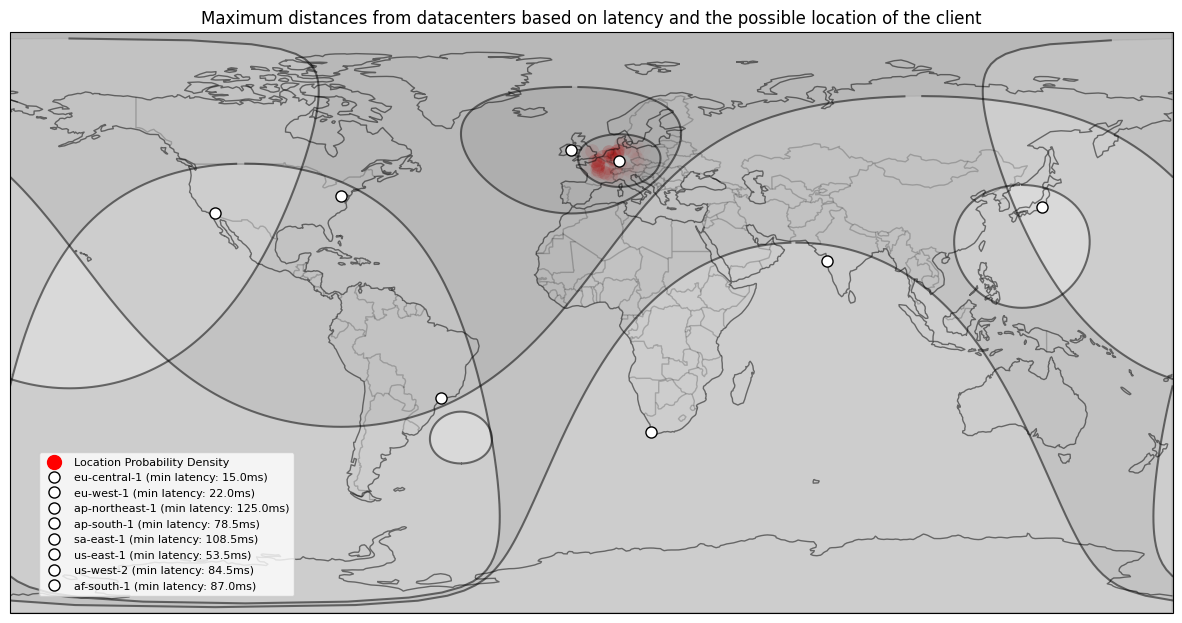

In [103]:
import pandas as pd
import matplotlib as plt
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
from cartopy.geodesic import Geodesic
import time
from shapely.geometry import Polygon, MultiPolygon, Point
from shapely.ops import unary_union
import geopandas as gpd
from scipy.spatial import ConvexHull

def calculate_max_distance(time_ms):
    """
    Calculate the maximum possible distance in kilometers given a time delay in milliseconds.
    Returns both minimum and maximum possible distances based on routing factors.
    """
    SPEED_OF_LIGHT = 299792.458  # km/s
    FIBER_FACTOR = 2/3  # typical speed in fiber is ~2/3 of c
    ROUTING_FACTOR_MIN = 1.1  # additional delay from routing and electronics
    ROUTING_FACTOR_MAX = 2  # additional delay from routing and electronics
    LAMBDA_STARTUP = 10  # ms for AWS Lambda cold start
    
    # Convert milliseconds to seconds and calculate distance
    time_s = max(0, (time_ms - LAMBDA_STARTUP)) / 1000
    max_distance_min = (time_s * SPEED_OF_LIGHT * FIBER_FACTOR) / ROUTING_FACTOR_MAX
    max_distance_max = (time_s * SPEED_OF_LIGHT * FIBER_FACTOR) / ROUTING_FACTOR_MIN
    return max_distance_min, max_distance_max

# coordinates of data centers - switch from (lat, lon) to (lon, lat)
DATACENTERS = {
    'eu-central-1': (8.6821, 50.1109),    # Frankfurt
    'eu-west-1': (-6.2603, 53.3498), # Ireland
    'ap-northeast-1': (139.6503, 35.6762), # Tokyo
    'ap-south-1': (72.8777, 19.0760), # Mumbai
    'sa-east-1': (-46.6333, -23.5505),    # São Paulo
    'us-east-1': (-77.4874, 39.0438),      # N. Virginia
    'us-west-2': (-116.4568, 33.7490),   # Oregon
    'af-south-1': (18.4241, -33.9249), # Cape Town
}

# Get current timestamp
current_time = time.time() * 1000  # convert to milliseconds
n_minutes_ago = current_time - (20* 60 * 60 * 1000)  # 10 minutes in milliseconds

# Filter for recent files
recent_data = []
for file in os.listdir('../s3/triangulation/'):
    if file.endswith('.json'):
        with open(f'../s3/triangulation/{file}', 'r') as f:
            contents = json.load(f)
            if contents.get('lambdaStartTimestamp', 0) > n_minutes_ago:
                recent_data.append(contents)


recent_df = pd.DataFrame(recent_data)



# Calculate all clock shifts first
clock_shifts = []
nonce_shifts = {}  # Store clock shifts by nonce
for nonce in recent_df['nonce'].unique():
    nonce_df = recent_df[recent_df['nonce'] == nonce]
    
    try:
        lambda_start = int(nonce_df[(nonce_df.event == 'nonceGeneratedAtMaster')].lambdaStartTimestamp.iloc[0])
        nonce_sent = int(nonce_df[(nonce_df.event == 'nonceGeneratedAtMaster')].nonceSentTime.iloc[0])
        client_start = int(nonce_df[~(nonce_df.clientStartTimestamp.isna())].clientStartTimestamp.iloc[0])
        client_received = int(nonce_df[~(nonce_df.clientReceivedNonceTimestamp.isna())].clientReceivedNonceTimestamp.iloc[0])
        
        time_shift = ((lambda_start - client_start) + (nonce_sent - client_received)) / 2
        clock_shifts.append(time_shift)
        nonce_shifts[nonce] = time_shift
    except (IndexError, KeyError):
        continue

# Calculate median and identify valid nonces
median_shift = np.median(clock_shifts)
valid_nonces = {nonce for nonce, shift in nonce_shifts.items() 
                if abs(shift - median_shift) <= 20}

print(f"\nMedian clock shift: {median_shift:.2f} ms")
print(f"Valid nonces: {len(valid_nonces)} out of {len(nonce_shifts)}")
print("\nAll time shifts (ms):")
for nonce, shift in nonce_shifts.items():
    valid = "✓" if nonce in valid_nonces else "✗"
    print(f"Nonce {nonce}: {shift:.2f} ms, {median_shift - shift:.2f} ms, {valid}")

# Find minimum latencies using only valid nonces
min_latencies = {
    'eu-central-1': float('inf'),
    'ap-northeast-1': float('inf'),
    'ap-south-1': float('inf'),
    'eu-west-1': float('inf'),
    'sa-east-1': float('inf'),
    'us-east-1': float('inf'),
    'us-west-2': float('inf'),
    'af-south-1': float('inf')
}


for nonce in valid_nonces:  # Only process valid nonces
    nonce_df = recent_df[recent_df['nonce'] == nonce]
    
    try:
        client_received = int(nonce_df[~(nonce_df.clientReceivedNonceTimestamp.isna())].clientReceivedNonceTimestamp.iloc[0])
        
        # Update minimum latencies using the specific nonce's clock shift
        for region in min_latencies.keys():
            try:
                request_received = nonce_df[(nonce_df.awsRegionOfSlave == region)].lambdaStartTimestamp.iloc[0]
                latency = request_received - (client_received + nonce_shifts[nonce])
                min_latencies[region] = min(min_latencies[region], latency)
            except (IndexError, KeyError):
                continue
                
    except (IndexError, KeyError):
        continue

print("\nMinimum latencies from measurements in the last 10 minutes:")
for region, latency in min_latencies.items():
    if latency != float('inf'):
        print(f"{region}: {latency:.2f} ms")
        print(f"Maximum distance: {calculate_max_distance(latency)[0]:.2f} km")

# Create the visualization
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, alpha=0.5)  # Make coastline slightly transparent
ax.add_feature(cfeature.BORDERS, alpha=0.2)    # Make borders very light
ax.set_global()

# Calculate distances from minimum latencies
min_distances = {
    region: calculate_max_distance(latency)[1]
    for region, latency in min_latencies.items()
    if latency != float('inf')
}

# Create list to store all circle polygons
circle_polygons = []

# Plot each datacenter and its minimum latency circle
colors = ['black'] * len(DATACENTERS)
geod = Geodesic()

# Replace the geopandas dataset loading with direct download
world = gpd.read_file(
    "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
)

# After loading the world data, create a unified land polygon
land = unary_union([geom for geom in world.geometry])

# First, find the smallest radius and its corresponding datacenter
min_radius_dc = min(((dc, min_distances[dc]) for dc in min_distances), key=lambda x: x[1])
smallest_circle_dc = min_radius_dc[0]
smallest_radius = min_radius_dc[1]

# Calculate area of smallest circle (in km²)
circle_area = np.pi * (smallest_radius ** 2)

# Adjust number of points based on area
# Use 100 points per 1 million km² as a baseline
points_per_million_km2 = 30
n_points = max(100, int((circle_area / 1_000_000) * points_per_million_km2))

# Generate sample points within the smallest circle
sample_points = []
valid_weights = []

for i in range(n_points):
    angle = (360 * i / n_points)  # Calculate angle in degrees directly
    dc_lon, dc_lat = DATACENTERS[smallest_circle_dc]  # Get coordinates of smallest circle DC
    r = np.sqrt(np.random.random()) * smallest_radius * 1000  # Convert to meters
    point = geod.direct([(dc_lon, dc_lat)], angle, r)
    lon = point[0][0]
    if abs(lon - dc_lon) > 180:
        lon = lon - 360 if lon > 0 else lon + 360
    sample_points.append((lon, point[0][1]))

sample_points = np.array(sample_points)

# Modify the point validation to separate land and water points
plot_points = []
plot_weights = []
hull_points = []
hull_weights = []

# Pre-calculate distance limits for all datacenters
dc_limits = {
    dc_name: calculate_max_distance(min_latencies[dc_name])
    for dc_name in min_distances
}

for point in sample_points:
    weights = []  # Store weights for each datacenter
    valid = True
    
    # Check against all datacenters at once
    for dc_name, coords in DATACENTERS.items():
        if dc_name not in min_distances:
            continue
            
        dc_lon, dc_lat = coords
        dist = geod.inverse([(point[0], point[1])], [(dc_lon, dc_lat)])[0][0]
        dist_km = dist / 1000
        
        max_dist_min, max_dist_max = dc_limits[dc_name]
        
        # Early exit if point is outside maximum distance
        if dist_km > max_dist_max:
            valid = False
            break
            
        # Calculate weight if point is valid
        if dist_km <= max_dist_min:
            weights.append(1.0)
        else:
            # Linear interpolation between min and max distances
            weight = 1.0 - (dist_km - max_dist_min) / (max_dist_max - max_dist_min)
            weights.append(max(min(weight, 1.0), 0.0))
    
    if valid and weights:
        point_weight = np.prod(weights)
        hull_points.append(point)
        hull_weights.append(point_weight)
        
        # Only add to plot points if on land
        point_geom = Point(point[0], point[1])
        if land.contains(point_geom):
            plot_points.append(point)
            plot_weights.append(point_weight)

# Convert to numpy arrays
plot_points = np.array(plot_points)
plot_weights = np.array(plot_weights)
hull_points = np.array(hull_points)
hull_weights = np.array(hull_weights)

# Normalize weights for plotting
if len(plot_weights) > 0:
    plot_weights = (plot_weights - plot_weights.min()) / (plot_weights.max() - plot_weights.min())

# Use plot_points for scatter plot
if len(plot_points) > 0:
    scatter = ax.scatter(plot_points[:, 0], plot_points[:, 1],
              c='red', alpha=plot_weights ** 2 * 0.2, s=100, edgecolor='none',
              transform=ccrs.PlateCarree())
    
    # Add a hidden point just for the legend
    hidden_point = ax.scatter([-1000], [-1000], c='red', s=100,  # Plot outside visible area
                             label='Location Probability Density')

    # Add legend with the proxy artist
    ax.legend(handles=[hidden_point] + [plt.Line2D([], [], marker='o', color='white', 
             markeredgecolor='black', markersize=8, linestyle='None', 
             label=f"{dc_name} (min latency: {min_latencies[dc_name]:.1f}ms)") 
             for dc_name in min_distances], 
             prop={'size': 8}, loc='lower left', bbox_to_anchor=(0.02, 0.02))

# Plot datacenter circles
for dc_name, coords in DATACENTERS.items():
    if dc_name not in min_distances:
        continue
        
    lon, lat = coords
    radius_km = min_distances[dc_name]
    
    # Generate circle points using geodesic
    circle_points = geod.circle(lon=lon, lat=lat, radius=radius_km * 1000)
    
    # Plot the datacenter point and circle
    ax.plot(lon, lat, 'o', color='white', markeredgecolor='black', markersize=8, transform=ccrs.PlateCarree(),
            label=f"{dc_name} (min latency: {min_latencies[dc_name]:.1f}ms)")
    
    polygon = mpatches.Polygon(circle_points, 
                             color='black',
                             alpha=0.05,
                             transform=ccrs.Geodetic())
    ax.add_patch(polygon)
    ax.plot(circle_points[:, 0], circle_points[:, 1], 
            color='black', transform=ccrs.Geodetic(), alpha=0.5)

# Add legend and title
ax.legend(prop={'size': 8}, loc='lower left', bbox_to_anchor=(0.02, 0.02))
plt.title('Maximum distances from datacenters based on latency and the possible location of the client')

# Show the plot
plt.show()

In [107]:
# Use hull_points for convex hull calculation
if len(hull_points) > 0:
    hull = ConvexHull(hull_points)
    hull_vertices = hull_points[hull.vertices]
    
    # Close the polygon by adding the first point at the end
    hull_vertices = np.vstack([hull_vertices, hull_vertices[0]])
    
    # Create a Shapely polygon from hull points
    hull_polygon = Polygon(hull_vertices)
    
    # Find intersecting countries
    intersecting_countries = []
    for idx, country in world.iterrows():
        if country.geometry.intersects(hull_polygon):
            # Use ISO_A2 column instead of NAME
            iso_code = country['ISO_A2']
            if iso_code != '-99':  # Skip invalid/missing codes
                intersecting_countries.append(iso_code)
    
    print("\nPossible countries of origin (ISO codes):")
    print(intersecting_countries)



Possible countries of origin (ISO codes):
['SE', 'PL', 'AT', 'HU', 'DE', 'HR', 'CH', 'LU', 'BE', 'NL', 'IT', 'DK', 'GB', 'SI', 'SK', 'CZ', 'BA']


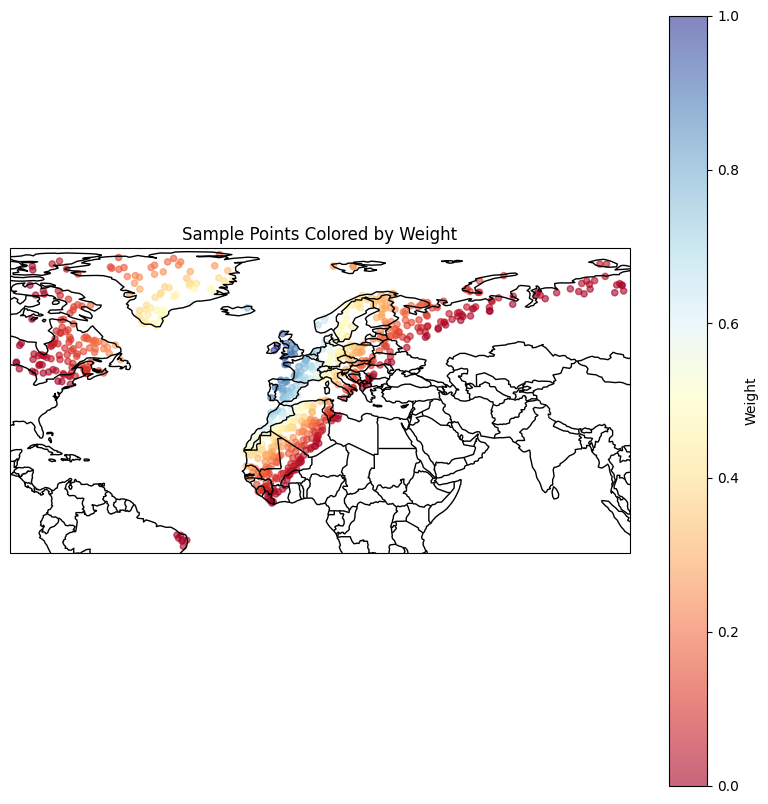

In [99]:
# Create a new figure for the zoomed sample points
plt.figure(figsize=(10, 10))
ax_zoom = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax_zoom.add_feature(cfeature.COASTLINE)
ax_zoom.add_feature(cfeature.BORDERS)

# Convert to numpy arrays for indexing
valid_points = np.array(valid_points)
valid_weights = np.array(valid_weights)

# Plot sample points colored by weight
scatter = ax_zoom.scatter(valid_points[:, 0], valid_points[:, 1], 
                         c=valid_weights, 
                         cmap='RdYlBu',  # Red (0) to Blue (1)
                         s=20,  # Point size
                         alpha=0.6,
                         transform=ccrs.PlateCarree())

# Add a colorbar
plt.colorbar(scatter, label='Weight')

# Zoom to the region of interest
margin = 2  # degrees
min_lon, max_lon = valid_points[:, 0].min() - margin, valid_points[:, 0].max() + margin
min_lat, max_lat = valid_points[:, 1].min() - margin, valid_points[:, 1].max() + margin
ax_zoom.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Add title
plt.title('Sample Points Colored by Weight')

# Show the plot
plt.show()
